#**Projet final - Natural Language Processing**

ESCHYLLE Annaly Sixtine, OUM Anthony, TRAN Laurent & VO THANH William - 2023/2024

## Table des matières :

*   Partie 1 : Initialisation et analyse de la dataset
*   Partie 2 : Pre-Processing
*   Partie 3 : Topic Modelling/Clustering
*   Partie 4 : Metrics
*   Partie 5 : Conclusion



## **Partie 1 : Initialisation et analyse de la dataset**

###Ajout des librairies

In [ ]:
!python -m spacy download en_core_web_md

2023-12-18 19:46:30.039212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 19:46:30.039289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 19:46:30.040570: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 19:46:31.113898: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 10.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
import re
import itertools
import spacy
import os
import secrets
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet

from itertools import chain

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec, Phrases, KeyedVectors
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess

# from pattern.en import pluralize, singularize
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

from spacy.parts_of_speech import IDS as POS_map

import seaborn as sns

from wordcloud import WordCloud, STOPWORDS



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Ajout et exploration du Dataset

#### Ajout de la dataset

In [ ]:
df = pd.read_json('/content/News_Category_Dataset_v2.json',lines=True)
df

category                                           headline  \
0               CRIME  There Were 2 Mass Shootings In Texas Last Week...   
1       ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...   
2       ENTERTAINMENT    Hugh Grant Marries For The First Time At Age 57   
3       ENTERTAINMENT  Jim Carrey Blasts 'Castrato' Adam Schiff And D...   
4       ENTERTAINMENT  Julianna Margulies Uses Donald Trump Poop Bags...   
...               ...                                                ...   
200848           TECH  RIM CEO Thorsten Heins' 'Significant' Plans Fo...   
200849         SPORTS  Maria Sharapova Stunned By Victoria Azarenka I...   
200850         SPORTS  Giants Over Patriots, Jets Over Colts Among  M...   
200851         SPORTS  Aldon Smith Arrested: 49ers Linebacker Busted ...   
200852         SPORTS  Dwight Howard Rips Teammates After Magic Loss ...   

                 authors                                               link  \
0        Melissa Jeltsen  https://www.huffingtonpost.com/entry/texas-ama...   
1          Andy McDonald  https://www.huffingtonpost.com/entry/will-smit...   
2             Ron Dicker  https://www.huffingtonpost.com/entry/hugh-gran...   
3             Ron Dicker  https://www.huffingtonpost.com/entry/jim-carre...   
4             Ron Dicker  https://www.huffingtonpost.com/entry/julianna-...   
...                  ...                                                ...   
200848  Reuters, Reuters  https://www.huffingtonpost.com/entry/rim-ceo-t...   
200849                    https://www.huffingtonpost.com/entry/maria-sha...   
200850                    https://www.huffingtonpost.com/entry/super-bow...   
200851                    https://www.huffingtonpost.com/entry/aldon-smi...   
200852                    https://www.huffingtonpost.com/entry/dwight-ho...   

                                        short_description       date  
0       She left her husband. He killed their children... 2018-05-26  
1                                Of course it has a song. 2018-05-26  
2       The actor and his longtime girlfriend Anna Ebe... 2018-05-26  
3       The actor gives Dems an ass-kicking for not fi... 2018-05-26  
4       The "Dietland" actress said using the bags is ... 2018-05-26  
...                                                   ...        ...  
200848  Verizon Wireless and AT&T are already promotin... 2012-01-28  
200849  Afterward, Azarenka, more effusive with the pr... 2012-01-28  
200850  Leading up to Super Bowl XLVI, the most talked... 2012-01-28  
200851  CORRECTION: An earlier version of this story i... 2012-01-28  
200852  The five-time all-star center tore into his te... 2012-01-28  

[200853 rows x 6 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [ ]:
# shape of the dataset
print(df.shape)
# total number of unique categories
print("Nombre de catégories :",df['category'].nunique())

(200853, 6)
Nombre de catégories : 41


Nous observons que notre ensemble de données est constitué de 6 colonnes et de 200 853 lignes, avec un total de 41 catégories, comprenant CATEGORY, HEADLINE, AUTHORS, LINK, SHORT_DESCRIPTION et DATE. Pour commencer notre analyse, nous nous savons d'ores et déja que nous garderons les colonnes HEADLINE et SHORT_DESCRIPTION car ils contiennent des textes riches en informations qui seront prioritaires pour la mise en œuvre du topic modeling/clustering. Ces deux colonnes devraient fournir les éléments essentiels pour extraire des thèmes significatifs à partir de notre ensemble de données.

Regardons maintenant pour les 3 autres colonnes.
- **Date** : En ce qui concerne la colonne DATE, nous estimons qu'elle ne serait pas nécessaire pour le topic modeling/clustering, car les informations temporelles pourraient introduire un biais dans l'analyse des thèmes. En retirant cette colonne, nous nous concentrons davantage sur le contenu textuel, favorisant ainsi une représentation plus équilibrée des sujets sans l'influence potentielle de tendances temporelles.

Pour ce qui est des **auteurs** et des **liens URL**, nous allons regarder cela tout de suite.

#### Etude de la pertinence des données des auteurs

Faisons un Top 20 des auteurs avec leurs nombres d'articles par catégorie.

In [ ]:
# Compter le nombre d'occurrences de chaque auteur
author_counts = df['authors'].value_counts()

# Sélectionner les 20 auteurs les plus redondants
top_authors = author_counts.head(20).index.tolist()

# Créer un dictionnaire pour stocker les informations pour chaque auteur
author_info = {}

# Parcourir les données pour chaque auteur sélectionné
for author in top_authors:
    # Filtrer les lignes correspondant à l'auteur
    author_data = df[df['authors'] == author]

    # Obtenir les catégories distinctes et le nombre d'articles pour chaque catégorie
    category_counts = author_data.groupby('category').size().sort_values(ascending=False).to_dict()

    # Stocker les informations dans le dictionnaire
    author_info[author] = {
        'categories': list(category_counts.keys()),
        'articles_count': len(author_data),
        'category_counts': category_counts
    }

# Afficher les résultats
print("Nombre d'articles par catégorie pour chaque auteur :")
for author, info in author_info.items():
    print(f"Auteur : {author}")
    print(f"Nombre total d'articles : {info['articles_count']}")
    print("Nombre d'articles par catégorie :")
    for category, count in info['category_counts'].items():
        print(f" - Catégorie : {category}, Articles : {count}")
    print("\n")

Nombre d'articles par catégorie pour chaque auteur :
Auteur : 
Nombre total d'articles : 36620
Nombre d'articles par catégorie :
 - Catégorie : WELLNESS, Articles : 4999
 - Catégorie : POLITICS, Articles : 3535
 - Catégorie : STYLE & BEAUTY, Articles : 2526
 - Catégorie : PARENTING, Articles : 2268
 - Catégorie : WEDDINGS, Articles : 1948
 - Catégorie : FOOD & DRINK, Articles : 1804
 - Catégorie : ENTERTAINMENT, Articles : 1746
 - Catégorie : DIVORCE, Articles : 1731
 - Catégorie : THE WORLDPOST, Articles : 1466
 - Catégorie : TRAVEL, Articles : 1405
 - Catégorie : QUEER VOICES, Articles : 1065
 - Catégorie : BLACK VOICES, Articles : 1006
 - Catégorie : BUSINESS, Articles : 989
 - Catégorie : CRIME, Articles : 953
 - Catégorie : SPORTS, Articles : 910
 - Catégorie : HOME & LIVING, Articles : 794
 - Catégorie : WORLDPOST, Articles : 774
 - Catégorie : COMEDY, Articles : 729
 - Catégorie : ENVIRONMENT, Articles : 651
 - Catégorie : GREEN, Articles : 559
 - Catégorie : SCIENCE, Articles :

Regardons maintenant le nombres d'articles par catégorie pour tous les auteurs avec plus de 100 articles



In [ ]:
# Compter le nombre d'occurrences de chaque auteur
author_counts = df['authors'].value_counts()

# Sélectionner tous les auteurs ayant écrit plus de 100 articles
selected_authors = author_counts[author_counts > 100].index.tolist()

# Créer un dictionnaire pour stocker les informations pour chaque auteur
author_info = {}

# Parcourir les données pour chaque auteur
for author in selected_authors:
    # Filtrer les lignes correspondant à l'auteur
    author_data = df[df['authors'] == author]

    # Obtenir le nombre total d'articles de l'auteur
    total_articles = len(author_data)

    # Continuer uniquement si l'auteur a écrit plus de 100 articles
    if total_articles > 100:
        # Obtenir les catégories distinctes et le nombre d'articles pour chaque catégorie
        category_counts = author_data.groupby('category').size().sort_values(ascending=False).to_dict()

        # Calculer la part en pourcentage pour chaque catégorie
        category_percentages = {category: count / total_articles * 100 for category, count in category_counts.items()}

        # Stocker les informations dans le dictionnaire
        author_info[author] = {
            'categories': list(category_counts.keys()),
            'articles_count': total_articles,
            'category_counts': category_counts,
            'category_percentages': category_percentages
        }

# Afficher les résultats pour les auteurs ayant écrit plus de 100 articles
for author, info in author_info.items():
    print(f"Auteur : {author}")
    print(f"Nombre total d'articles : {info['articles_count']}")
    print("Nombre d'articles par catégorie (ordre décroissant) :")
    for category, count in info['category_counts'].items():
        percentage = info['category_percentages'][category]
        print(f" - Catégorie : {category}, Articles : {count}, Pourcentage : {percentage:.2f}%")
    print("\n")

Auteur : 
Nombre total d'articles : 36620
Nombre d'articles par catégorie (ordre décroissant) :
 - Catégorie : WELLNESS, Articles : 4999, Pourcentage : 13.65%
 - Catégorie : POLITICS, Articles : 3535, Pourcentage : 9.65%
 - Catégorie : STYLE & BEAUTY, Articles : 2526, Pourcentage : 6.90%
 - Catégorie : PARENTING, Articles : 2268, Pourcentage : 6.19%
 - Catégorie : WEDDINGS, Articles : 1948, Pourcentage : 5.32%
 - Catégorie : FOOD & DRINK, Articles : 1804, Pourcentage : 4.93%
 - Catégorie : ENTERTAINMENT, Articles : 1746, Pourcentage : 4.77%
 - Catégorie : DIVORCE, Articles : 1731, Pourcentage : 4.73%
 - Catégorie : THE WORLDPOST, Articles : 1466, Pourcentage : 4.00%
 - Catégorie : TRAVEL, Articles : 1405, Pourcentage : 3.84%
 - Catégorie : QUEER VOICES, Articles : 1065, Pourcentage : 2.91%
 - Catégorie : BLACK VOICES, Articles : 1006, Pourcentage : 2.75%
 - Catégorie : BUSINESS, Articles : 989, Pourcentage : 2.70%
 - Catégorie : CRIME, Articles : 953, Pourcentage : 2.60%
 - Catégorie :

Au vu des résultats, nous avons décidé de ne pas garder les auteurs car s'ils sont inclus, ils peuvent influencer les résultats en fonction de leurs intérêts ou de leurs biais.<br>
Par exemple, un auteur qui écrit principalement sur des sujets politiques peut faire en sorte que les sujets politiques soient surreprésentés dans les résultats du modèle alors qu'il peut écrire des articles sur des sujets très différents, tels que la tech, le sport, ou la culture.



#### Etude de la pertinence des données des liens URL

Un lien URL typique, tel que https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89, contient des informations pouvant être utilisées comme mots-clés pertinents. <br>Dans ce cas, les éléments tels que "texas", "amanda", "painter", "mass-shooting" et "us" peuvent être extraits pour enrichir notre analyse. Cependant, les préfixes et suffixes des liens URL ne sont pas nécessaires à cette fin. <br>
Afin d'ajouter plus de visibilité sur le contenu les liens url et decider de leurs pertinences, nous allons faire plusieurs actions.<br>Ainsi, la première étape consiste à éliminer ces parties non essentielles afin de conserver uniquement les éléments pertinents.

In [ ]:
df_link = df[['link']].copy()
# Appliquer la transformation sur la colonne 'cleaned_link'
df_link['cleaned_link'] = df['link'].str.extract(r'/entry/(.*?)_us_')

# Afficher le DataFrame avec la nouvelle colonne 'cleaned_link'
print(df_link[['link', 'cleaned_link']])


                                                     link  \
0       https://www.huffingtonpost.com/entry/texas-ama...   
1       https://www.huffingtonpost.com/entry/will-smit...   
2       https://www.huffingtonpost.com/entry/hugh-gran...   
3       https://www.huffingtonpost.com/entry/jim-carre...   
4       https://www.huffingtonpost.com/entry/julianna-...   
...                                                   ...   
200848  https://www.huffingtonpost.com/entry/rim-ceo-t...   
200849  https://www.huffingtonpost.com/entry/maria-sha...   
200850  https://www.huffingtonpost.com/entry/super-bow...   
200851  https://www.huffingtonpost.com/entry/aldon-smi...   
200852  https://www.huffingtonpost.com/entry/dwight-ho...   

                                             cleaned_link  
0                      texas-amanda-painter-mass-shooting  
1       will-smith-joins-diplo-and-nicky-jam-for-the-o...  
2                                      hugh-grant-marries  
3                        ji

Nous ferons ensuite la suppression des tirets en remplaçant les "-" par des espaces

In [ ]:
# Remplacer les "-" par des espaces dans la colonne 'cleaned_link'
df_link['cleaned_link'] = df_link['cleaned_link'].str.replace('-', ' ')

# Afficher le DataFrame avec la colonne 'cleaned_link' modifiée
print(df_link[['link', 'cleaned_link']])

                                                     link  \
0       https://www.huffingtonpost.com/entry/texas-ama...   
1       https://www.huffingtonpost.com/entry/will-smit...   
2       https://www.huffingtonpost.com/entry/hugh-gran...   
3       https://www.huffingtonpost.com/entry/jim-carre...   
4       https://www.huffingtonpost.com/entry/julianna-...   
...                                                   ...   
200848  https://www.huffingtonpost.com/entry/rim-ceo-t...   
200849  https://www.huffingtonpost.com/entry/maria-sha...   
200850  https://www.huffingtonpost.com/entry/super-bow...   
200851  https://www.huffingtonpost.com/entry/aldon-smi...   
200852  https://www.huffingtonpost.com/entry/dwight-ho...   

                                             cleaned_link  
0                      texas amanda painter mass shooting  
1       will smith joins diplo and nicky jam for the o...  
2                                      hugh grant marries  
3                        ji

Nous trouvons ici aussi que les liens vers les articles de presse ne sont pas strictement nécessaires au processus de topic modeling. <br>
Le titre et la short description peuvent fournir suffisamment d'informations pour que le modèle puisse comprendre le sujet de l'article.<br>
En effet, le lien est souvent redondant avec le titre et la short description et les informations supplémentaires qu'il contient ne sont pas souvent pertinentes pour la classification. <br><br>


En conclusion, les liens URL, tout comme les informations sur les auteurs, apparaissent comme des éléments superflus pour notre objectif de topic modeling/clustering. Ces données ne contribuent pas de manière significative à la compréhension des thèmes sous-jacents dans notre ensemble de données. Ainsi, nous avons opté pour leur exclusion afin de simplifier l'analyse et de concentrer davantage notre modèle sur les aspects textuels essentiels.

#### Suppression des données non requises

Ainsi, nous ne gardons que les données qui nous serons utiles, donc headline et short_description. Pour ce qui est de la colonne "CATEGORY", elle est encore ici en tant qu'indicatif mais nous l'enlèverons plus tard. Regardons maintenant notre dataset avec seulement les données qui nous intéressent.

In [ ]:
new_df = df.drop(columns=['authors','link','date'])
new_df.head()

category                                           headline  \
0          CRIME  There Were 2 Mass Shootings In Texas Last Week...   
1  ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...   
2  ENTERTAINMENT    Hugh Grant Marries For The First Time At Age 57   
3  ENTERTAINMENT  Jim Carrey Blasts 'Castrato' Adam Schiff And D...   
4  ENTERTAINMENT  Julianna Margulies Uses Donald Trump Poop Bags...   

                                   short_description  
0  She left her husband. He killed their children...  
1                           Of course it has a song.  
2  The actor and his longtime girlfriend Anna Ebe...  
3  The actor gives Dems an ass-kicking for not fi...  
4  The "Dietland" actress said using the bags is ...

In [ ]:
# Afficher le top 10 des catégories par le nombre d'articles
top_categories = new_df['category'].value_counts().head(10)

# Afficher les résultats
print("Top 10 des catégories par le nombre d'articles :")
print(top_categories)

Top 10 des catégories par le nombre d'articles :
POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
Name: category, dtype: int64


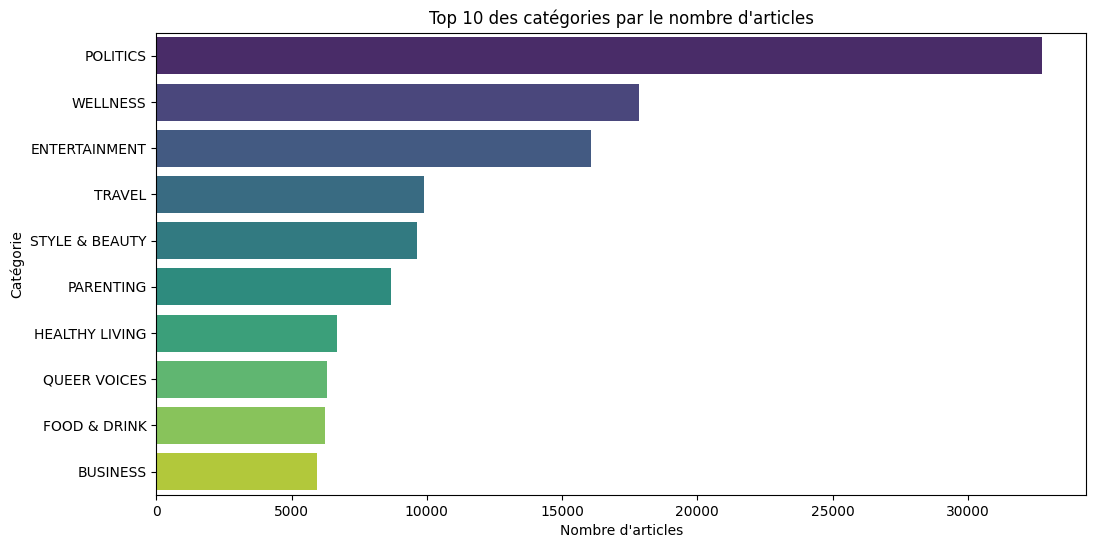

In [ ]:
# Créer un barplot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")

# Ajouter des étiquettes et un titre
plt.xlabel('Nombre d\'articles')
plt.ylabel('Catégorie')
plt.title('Top 10 des catégories par le nombre d\'articles')

# Afficher le graphique
plt.show()

On constate ici que les catégories POLITICS, WELLNESS et ENTERTAINMENT se distinguent en ayant significativement plus d'articles que les autres catégories. Cela suscite des préoccupations quant à l'équilibre des données pour le topic modeling ou le clustering, car il existe une disparité notable entre le nombre d'articles dans ces trois premières catégories et les autres. Cette inégalité devrait influencer pré-pondérément le modèle, compromettant ainsi la représentativité des sujets ou des clusters identifiés.

#### Constitution de nos données

Faisons un split des mots dans le corpus qui concatène à la fois headline + short_description

In [ ]:
def dummy_word_split(texts):
    texts_out = []
    for text in texts:
        texts_out.append(text.split(" "))

    return texts_out

# Créer un nouveau DataFrame en combinant les colonnes "headline" et "short_description"
df_combined = new_df.assign(combined_text=df['headline'] + ' ' + df['short_description'])

# Text Split
splitted_texts = dummy_word_split(df_combined["combined_text"].tolist())
splitted_texts[0]

['There',
 'Were',
 '2',
 'Mass',
 'Shootings',
 'In',
 'Texas',
 'Last',
 'Week,',
 'But',
 'Only',
 '1',
 'On',
 'TV',
 'She',
 'left',
 'her',
 'husband.',
 'He',
 'killed',
 'their',
 'children.',
 'Just',
 'another',
 'day',
 'in',
 'America.']

Examinons l'occurrence de chaque mot dans le corpus. Nous constatons la présence de mots avec une fréquence élevée qui ne nous intéresse pas, car ils ne sont pas spécifiques à un topic ou cluster particulier.

In [ ]:
def compute_word_occurences(texts):
    """You have to define this function yourself. """

    words = itertools.chain.from_iterable(texts)

    word_count = pd.Series(words).value_counts()
    word_count = pd.DataFrame({"Word": word_count.index, "Count": word_count.values})

    return word_count

In [ ]:
compute_word_occurences(splitted_texts).head(1000)

Word   Count
0              the  178570
1               to  123003
2               of  104023
3                a  100901
4              and   97542
..             ...     ...
995            100     620
996       Daughter     620
997         weight     616
998  International     616
999        Olympic     615

[1000 rows x 2 columns]

Il est apparent que les données actuelles ne présentent pas d'intérêt significatif, car elles ne mettent pas en évidence les termes les plus utilisés. Afin d'améliorer la qualité de notre analyse, il est impératif de supprimer les stopwords de la colonne "combined_text". Nous le ferons dans une seconde étape ci-dessous.

#### Nombre moyen de mots par ligne

In [ ]:
# Exemple de comptage du nombre de mots pour chaque ligne
word_counts_per_line = [len(words) for words in splitted_texts]

# Afficher le nombre de mots pour les 5 premières lignes
for i in range(5):
    print(f"Nombre de mots dans la ligne {i + 1}: {len(splitted_texts[i])}")



Nombre de mots dans la ligne 1: 27
Nombre de mots dans la ligne 2: 20
Nombre de mots dans la ligne 3: 25
Nombre de mots dans la ligne 4: 25
Nombre de mots dans la ligne 5: 26


In [ ]:
# Colonne nb_words pour le nombre de mots pour chaque ligne
df_combined['nb_words'] = [len(words) for words in splitted_texts]

# Afficher les premières lignes du nouveau DataFrame
print(df_combined[['category', 'combined_text', 'nb_words']].head())


        category                                      combined_text  nb_words
0          CRIME  There Were 2 Mass Shootings In Texas Last Week...        27
1  ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...        20
2  ENTERTAINMENT  Hugh Grant Marries For The First Time At Age 5...        25
3  ENTERTAINMENT  Jim Carrey Blasts 'Castrato' Adam Schiff And D...        25
4  ENTERTAINMENT  Julianna Margulies Uses Donald Trump Poop Bags...        26


L'analyse du nombre de mots par ligne dans "splitted_texts" révèle une cohérence remarquable, oscillant généralement entre 20 et 30 mots par ligne. Cette constatation suggère une distribution relativement uniforme des données, sans la présence de valeurs aberrantes. Cette normalité dans la longueur des textes contribue à maintenir une homogénéité dans notre ensemble de données, ce qui est favorable à une analyse cohérente et équilibrée lors du topic modeling/clustering.

Regardons maintenant avec le nombre de caractères si une cohérence existe entre les catégories.

In [ ]:
# Maximum length of news in each category
lenmax_df = df_combined.groupby('category')['nb_words'].max().reset_index().sort_values(by='nb_words', ascending=False)
lenmax_df.head()


category  nb_words
24        POLITICS       245
40       WORLDPOST       224
4          COLLEGE       189
16  HEALTHY LIVING       176
34          TRAVEL       175

- Les catégories POLITICS WORLDPOST COLLEGE HEALTHY_LIVING et TRAVEL possèdent les longueurs de news les plus longues car il y a plus de mots.

- De plus, POLITICS, WELLNESS et ENTERTAINMENT TRAVEL sont les catégories ayant le plus de nombre d'article à leur sujet.

- On peut conclure que POLITICS et TRAVEL sont les 2 catégories les plus importantes à prendre en compte, elles possèdent à la fois le plus d'articles mais aussi des articles longs.

#### WordCloud

Maintenant, pour anticiper le résultat final, nous allons explorer les mots clés à retenir en utilisant des nuages de mots (word clouds).

(-0.5, 1599.5, 599.5, -0.5)

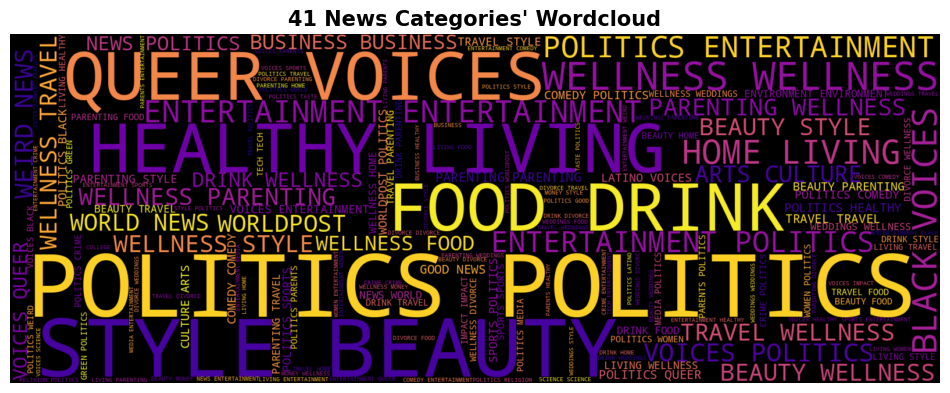

In [ ]:
# wordcloud of categories of news articles in our dataset
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(df_combined.category))

plt.title("41 News Categories' Wordcloud", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

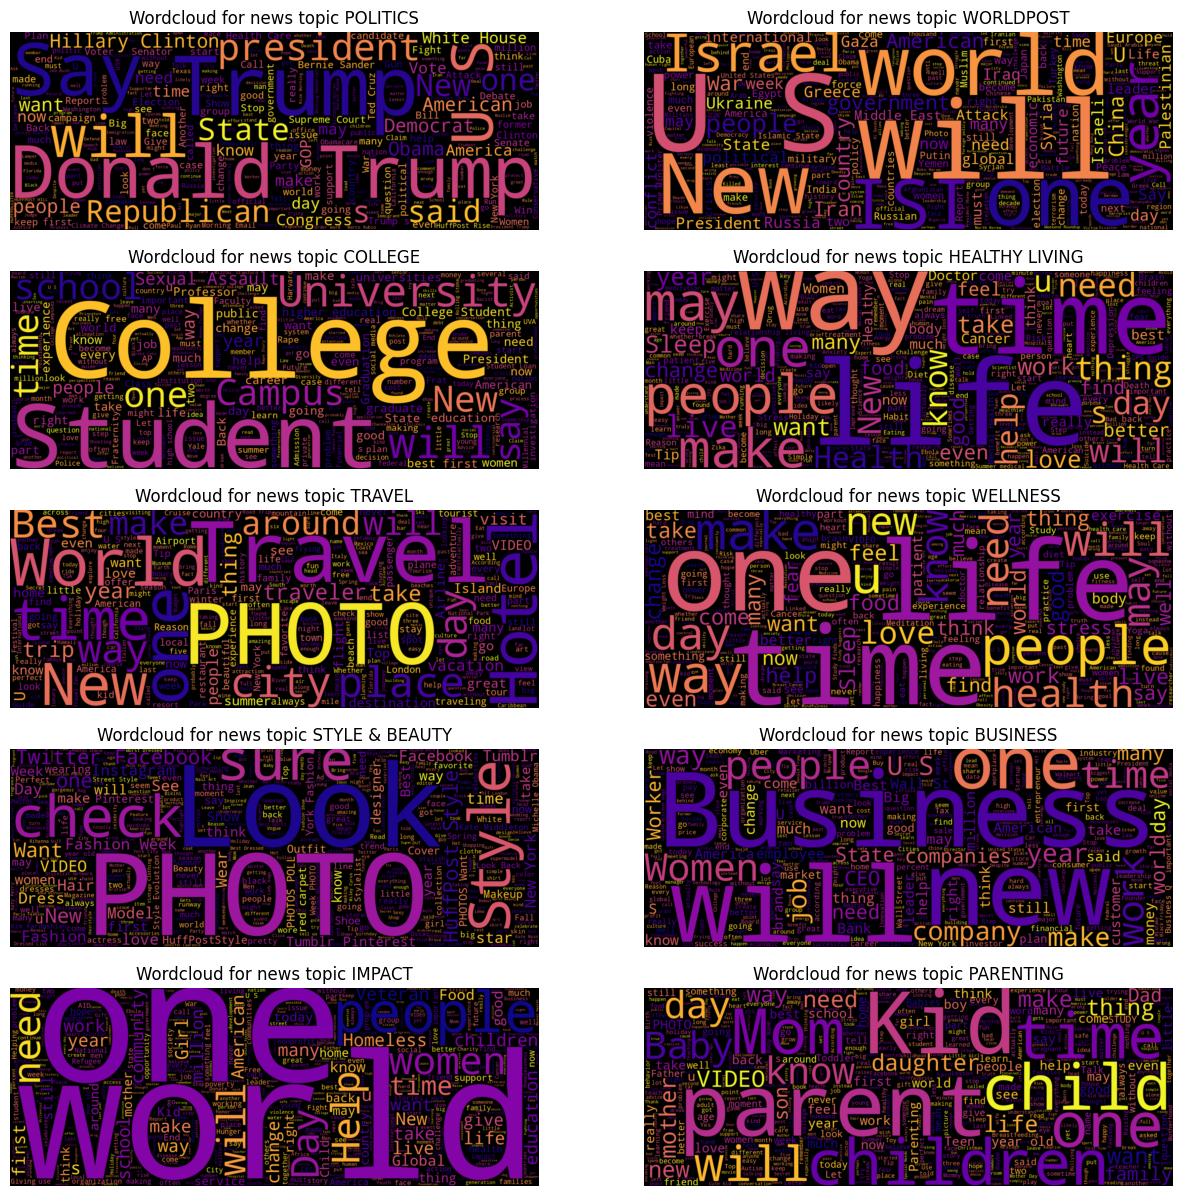

In [ ]:
# create new dataframe of category and length of each news articles in that categories
final_df = df_combined.copy()
final_df.drop('nb_words', inplace=True, axis=1)

# list of top 10  categories in out dataset
categories = lenmax_df['category'][:10].to_list()

# list of news articles of each top 10 categories list
articles_list = []

for i in categories:
    cat_ndf = final_df[final_df['category'] == i]
    cat_array = cat_ndf['combined_text'].values  # array of news articles text in each category
    articles_list.append(cat_array)

# create a wordcloud instance
wc1 = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=True,
               stopwords=STOPWORDS)

# plot the figure of 10 wordcloud from out dataset
plt.figure(figsize=(15,15))

for idx, j in enumerate(categories):
    plt.subplot(5,2,idx+1)
    cloud = wc1.generate(' '.join(articles_list[idx]))
    plt.imshow(cloud, interpolation= "bilinear")
    plt.title(f"Wordcloud for news topic {j}")
    plt.axis('off')

La bibliothèque WordCloud offre une vision globale de ce à quoi nos clusters devraient ressembler. Elle extrait les mots les plus fréquemment utilisés dans chaque catégorie pour les afficher sous forme de nuages de mots. Cette observation révèle une cohérence significative, où les mots les plus utilisés correspondent étroitement à leur thème respectif.

Cela confirme l'idée que les clusters produits par le modèle devraient être représentatifs de sujets distincts et pertinents, alignés sur les termes prédominants dans chaque catégorie.

##**Partie 2 : Pre-Processing**

#### Enlevons 15000 lignes

In [ ]:
# start with removing some data from politics dataframe ndf
politics_list = list(final_df[final_df['category'] == 'POLITICS'].index)
list_15 = politics_list[:15000] # list of 16000 row labels of POLITICS category

# drop these 15000 labels from the dataset
final_df2 = final_df.copy()
final_df2.drop(list_15, axis=0, inplace=True)

Comme mentionné précédemment, dans le but d'améliorer l'équité des données entre les catégories, nous avons choisi de réduire l'échelle de la catégorie "POLITICS" en supprimant 15 000 données. Cette démarche vise à équilibrer plus efficacement les différentes catégories, favorisant ainsi une meilleure équité dans notre ensemble de données.

#### Quality test (strings/NaN values)

Examinons à présent nos données pour détecter d'éventuels problèmes ou valeurs aberrantes en supprimant les lignes qui ne contiennent pas de contenu.

In [ ]:
def check_data_quality(texts):
    assert all([isinstance(t, str) for t in texts]), "Input data contains something different than strings."
    assert all([t != np.nan for t in texts]), "Input data contains NaN values."

    return True

def force_format(texts):
    return [str(t) for t in texts]

In [ ]:
texts = force_format(final_df2["combined_text"])
print(f"Is the combined_text dataset passing our data quality check?\n{check_data_quality(texts)}")

Is the combined_text dataset passing our data quality check?
True


#### Filtre regex

À présent, pour faciliter la concentration de notre modèle sur l'essentiel, nous allons appliquer un filtre regex afin de supprimer tous les éléments non essentiels à la compréhension du topic modeling/clustering. Cela inclut les ponctuations et les caractères spéciaux.

In [ ]:
def filter_text(texts_in):
    texts_out = re.sub(r'https?:\/\/[A-Za-z0-9_.-~\-]*', ' ', texts_in, flags=re.MULTILINE)
    texts_out = re.sub(r'[(){}\[\]<>]', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&amp;#.*;', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&gt;', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'â€™', "'", texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'\s+', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&#x200B;', ' ', texts_out, flags=re.MULTILINE)
    # Mail regex
    texts_out = re.sub(r'[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+\.[a-zA-Z0-9-_.]+', '', texts_out, flags=re.MULTILINE)
    # Phone regex
    texts_out = re.sub(r"\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4}", '', texts_out, flags=re.MULTILINE)
    # Remove names in twitter
    texts_out = re.sub(r'@\S+( |\n)', '', texts_out, flags=re.MULTILINE)

    # Remove starts commonly used on social media
    texts_out = re.sub(r'\*', '', texts_out, flags=re.MULTILINE)
    return texts_out

In [ ]:
texts = [filter_text(t) for t in texts]

#### Unication du text & Conversion des phrases en liste de mots

Nous pouvons maintenant procéder à la transformation de nos phrases en mots. Cette étape consiste à diviser chaque élément du corpus en mots individuels, ce qui permettra une analyse plus approfondie lors du topic modeling/clustering. Cette transformation facilitera la représentation des documents sous forme de sacs de mots (bag-of-words) ou d'autres représentations vectorielles, favorisant ainsi l'identification de thèmes ou de clusters pertinents dans notre ensemble de données.

In [ ]:
def sent_to_words(sentences):
    for sentence in tqdm(sentences):
        yield (simple_preprocess(str(sentence), deacc=True))


In [ ]:
texts = list(sent_to_words(texts))

100%|██████████| 185853/185853 [00:15<00:00, 12130.98it/s]


#### Stopwords


En ajustant notre liste de stopwords, nous avons optimisé la performance de notre modèle de topic modeling/clustering. En retirant des mots tels que

- "one,"
- "year,"
- "years,"
- "make,"
-  "time,"
-  "day,"
- "days,"
- "life,"
-  "people,"
-  "thing,"
-  "things,"
-  "think,"
-  "week,"
- "weeks"

qui étaient fréquemment présents mais moins informatifs, nous avons atténué le risque de biais dans la formation des clusters.

Cette mise à jour permet au modèle de se concentrer davantage sur des termes spécifiques et significatifs, améliorant ainsi la précision des résultats. Par exemple, en éliminant la fréquence élevée du mot "year," qui apparaissait 4765 fois, nous réduisons la probabilité de voir ce terme dominer inutilement plusieurs clusters traitant de thèmes distincts. Cela contribue à une représentation plus fine et nuancée des sujets au sein de nos clusters.

In [ ]:
def get_stopwords(additional_stopwords=[]):
    # Loading standard english stop words
    with open('/content/stopwords.txt', 'r') as f:
        stop_w = f.readlines()
    stopwords = [s.rstrip() for s in stop_w]

    # Adding stop words from sklearn
    stopwords = list(text.ENGLISH_STOP_WORDS.union(stopwords))

    # Adding words from a list if specified
    if additional_stopwords:
        stopwords += additional_stopwords

    # Removing duplicates
    stopwords = list(set(stopwords))

    # Removing some \n that were included in the native stopwords of sklearn ... WHY?
    stopwords = [s.replace("\n", "") for s in stopwords]

    stopwords = sorted(stopwords, key=str.lower)

    return stopwords

stopwords = get_stopwords(additional_stopwords=["trump"])

In [ ]:
texts = [[word for word in txt if word not in stopwords] for txt in tqdm(texts)]

100%|██████████| 185853/185853 [00:39<00:00, 4687.14it/s]


#### Bigram / Trigram

Après avoir éliminé les mots indésirables de notre corpus, nous pouvons maintenant gérer les bigrams et trigrams pour capturer des associations de mots significatives. Les bigrams consistent en paires consécutives de mots, tandis que les trigrams regroupent des séquences de trois mots. Cette approche permet de préserver des expressions multi-mots importantes pour la compréhension des thèmes, tout en réduisant le risque de bruit lié à la présence de stopwords ou de termes peu informatifs.

Par exemple, un bigram pertinent pourrait être "Donald Trump." En préservant cette association, le modèle de topic modeling/clustering serait mieux équipé pour identifier des sujets spécifiques liés à cet individu, plutôt que de traiter "Donald" et "Trump" de manière indépendante. L'incorporation de bigrams et trigrams contribue ainsi à une représentation plus précise et contextuelle des informations, améliorant la capacité du modèle à discerner des nuances et des relations plus fines entre les mots dans notre ensemble de données.

In [ ]:
def create_bigrams(texts, bigram_count=15, threshold=10, convert_sent_to_words=False, as_str=True):
    """Identify bigrams in texts and return the texts with bigrams integrated"""
    if convert_sent_to_words:
        texts = list(sent_to_words(texts))

    bigram_model = Phraser(Phrases(texts, min_count=bigram_count, threshold=threshold))

    if as_str:
        return [" ".join(bigram_model[t]) for t in texts]

    else:
        return [bigram_model[t] for t in texts]

def create_trigrams(texts, trigram_count=15, threshold=10, convert_sent_to_words=False, as_str=True):
    """Identify trigrams in texts and return the texts with trigrams integrated"""
    if convert_sent_to_words:
        texts = list(sent_to_words(texts))

    bigram_model = Phraser(Phrases(texts, min_count=bigram_count, threshold=threshold))

    if as_str:
        return [" ".join(bigram_model[t]) for t in texts]

    else:
        return [bigram_model[t] for t in texts]


In [ ]:
texts = create_bigrams(texts)

#### Lemmatization

Après avoir éliminé les mots indésirables de notre corpus, nous pouvons maintenant gérer les bigrams et trigrams pour capturer des associations de mots significatives. Les bigrams consistent en paires consécutives de mots, tandis que les trigrams regroupent des séquences de trois mots. Cette approche permet de préserver des expressions multi-mots importantes pour la compréhension des thèmes, tout en réduisant le risque de bruit lié à la présence de stopwords ou de termes peu informatifs.

Par exemple, dans le contexte de l'actualité politique, un bigram pertinent pourrait être "Donald Trump." En préservant cette association, le modèle de topic modeling/clustering serait mieux équipé pour identifier des sujets spécifiques liés à cet individu, plutôt que de traiter "Donald" et "Trump" de manière indépendante. L'incorporation de bigrams et trigrams contribue ainsi à une représentation plus précise et contextuelle des informations, améliorant la capacité du modèle à discerner des nuances et des relations plus fines entre les mots dans notre ensemble de données.

In [ ]:
def lemmatize_texts(texts,
                    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'],
                    forbidden_postags=[],
                    as_sentence=False,
                    get_postags=False,
                    spacy_model=None):
    texts_out = []

    if allowed_postags and forbidden_postags:
        raise ValueError("Can't specify both allowed and forbidden postags")

    if forbidden_postags:
        allowed_postags = list(set(POS_map.keys()).difference(set(forbidden_postags)))

    if not spacy_model:
        print("Loading spacy model")
        spacy_model = spacy.load('en_core_web_md')

    print("Beginning lemmatization process")
    total_steps = len(texts)

    docs = spacy_model.pipe(texts)

    for i, doc in tqdm(enumerate(docs), total=total_steps):
        if get_postags:
            texts_out.append(["_".join([token.lemma_, token.pos_]) for token in doc if token.pos_ in allowed_postags])
        else:
            texts_out.append(
                [token.lemma_ for token in doc if token.pos_ in allowed_postags])

    if as_sentence:
        texts_out = [" ".join(text) for text in texts_out]

    return texts_out


In [ ]:
l_texts = lemmatize_texts(texts,
                allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'X', 'PROPN'],
                get_postags=False)

Loading spacy model
Beginning lemmatization process


100%|██████████| 185853/185853 [05:35<00:00, 554.57it/s]


Voyons désormais notre nouvelle occurence après le nettoyage complet de nos datas.

In [ ]:
occurences = compute_word_occurences(l_texts)
occurences.head(20)

Word  Count
0    photo  12773
1    woman   8348
2     love   7975
3    world   7812
4    video   6820
5      don   6761
6    child   6724
7     work   6097
8      man   5594
9      kid   5364
10    feel   4919
11    live   4903
12    good   4715
13    home   4661
14     big   4589
15    make   4552
16  family   4546
17     win   4467
18  donald   4250
19   great   4191

l_texts correspond à notre dernier dataset après nettoyage.

## **Partie 3 : Topic Modeling/Clustering**

Utilisons maintenant pre-trained Word2Vec representations from spacy

Le vecteur que nous avons obtenu représente la façon dont le mot "this is a course" est encodé dans le modèle linguistique que nous avons chargé avec spaCy. Chaque nombre dans ce vecteur donne une idée de différentes caractéristiques sémantiques du mot. En d'autres termes, le modèle a assigné à "this is a course" des valeurs spécifiques pour des aspects tels que le contexte dans lequel il apparaît fréquemment. Ces valeurs sont calculées à partir d'un entraînement sur de grandes quantités de texte. En utilisant ce vecteur, on peut mesurer la similarité entre "course" et d'autres mots

In [ ]:
import spacy
nlp = spacy.load('en_core_web_md')
nlp("this is a course")[3].vector

array([-8.3098e-01, -3.4769e+00,  2.1100e+00, -1.4162e+00,  6.0022e-01,
        5.6999e+00,  4.7979e+00,  3.7671e+00, -1.3526e+00,  5.8118e-01,
        6.4907e+00,  1.1967e+00, -2.1825e+00, -2.1513e-01,  1.4625e+00,
        3.6772e-01,  5.5495e+00, -4.3644e-02, -1.0883e+00,  2.5740e+00,
       -3.5277e+00,  1.2697e+00, -2.4186e+00, -1.6382e+00, -2.0699e+00,
        1.5101e+00, -1.8956e+00, -2.9923e+00, -8.1198e-01,  3.4270e+00,
        1.1932e+00, -1.3166e+00,  3.0397e+00, -3.1066e+00,  1.7522e+00,
        2.4266e+00,  2.0176e+00,  3.0593e+00,  3.8190e+00,  2.1052e+00,
       -2.2864e+00,  1.7293e-01,  5.3730e-01, -1.5660e+00,  3.5266e-01,
        8.4540e-01, -2.3638e-01, -3.8492e+00, -4.8976e-01,  9.1584e-02,
       -2.2043e+00,  1.8355e-01, -5.9825e-02, -3.2379e+00, -1.4120e+00,
        3.6006e+00, -1.3546e+00, -1.4109e-02,  3.7713e+00,  3.6267e-01,
        2.2466e+00,  3.1978e+00, -2.7878e+00, -1.7055e+00,  4.3964e+00,
        3.3826e+00, -1.6804e+00, -2.1223e+00,  2.3021e+00,  2.68

Nous obtenons les représentations vectorielles des 100 premiers mots d'une liste d'occurrences. En d'autres termes, pour chaque mot présent dans la colonne "Word" du DataFrame, le code utilise spaCy pour extraire une représentation vectorielle. Ensuite, il crée un nouveau DataFrame appelé embeddings_df qui contient les mots et leurs représentations vectorielles.

In [ ]:
nlp = spacy.load('en_core_web_md')

def get_word_embeddings(texts, occurrences):
    words = []
    vector_representations = []

    # Parcourir les 100 premiers mots dans les occurrences
    for word in occurrences["Word"]:
        words.append(word)

        # Obtenir la représentation vectorielle du mot avec SpaCy
        vector_representations.append(nlp(word)[0].vector)

    # Créer un DataFrame avec les mots et leurs représentations vectorielles
    embeddings_df = pd.DataFrame({"Words": words, "Vector": vector_representations})

    return embeddings_df



La fonction "get_word_embeddings" avec "l_texts" et "occurrences" est utilisée pour créer la variable "embeddings_result". Les représentations vectorielles des mots dans la colonne "Word" de "occurrences" sont obtenues par cette fonction à l'aide de spaCy, qui ensuite crée un DataFrame qui relie chaque mot à sa représentation vectorielle dans la colonne "Vector". Par conséquent, les 100 premiers mots de "occurrences" sont inclus dans "embeddings_result".

In [ ]:
embeddings_result = get_word_embeddings(l_texts, occurences)

In [ ]:
print(embeddings_result)

            Words                                             Vector
0           photo  [1.1623, -0.41163, -4.8799, -2.886, 3.0018, -2...
1           woman  [0.76548, 1.0758, -1.633, -2.998, -0.82636, 0....
2            love  [2.0565, -3.2259, -5.7364, -6.146, 0.15748, -2...
3           world  [2.4253, 0.98187, 1.4646, -2.4369, 2.0922, 1.8...
4           video  [1.1741, 0.17231, -0.97109, -2.0432, -0.70151,...
...           ...                                                ...
75208     feedlot  [3.7266, 0.62343, -4.8736, 4.9211, -0.2477, -1...
75209      exiles  [-4.0833, 1.0738, 1.3032, 2.0576, 5.7871, 1.19...
75210       vidra  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
75211  trevorlive  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
75212       sumyk  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

[75213 rows x 2 columns]


In [ ]:
# Join the lists of lemmatized words into strings
Test_strings = [' '.join(text) for text in l_texts]

Les textes préalablement concaténés dans la liste Test_strings sont convertis en une matrice TF-IDF à l'aide du TfidfVectorizer de scikit-learn. Chaque document est représenté sous la forme d'un vecteur numérique dans cette matrice, où chaque élément quantifie l'importance relative d'un mot particulier dans ce document par rapport à l'ensemble du corpus. Les paramètres max_df et min_df sont configurés pour éliminer les termes trop fréquents ou trop rares. De plus, l'option stop_words='english' est utilisée pour filtrer les mots vides fréquents en anglais, améliorant la qualité de la représentation TF-IDF en éliminant des termes couramment présents mais peu informatifs.

In [ ]:
# Create a TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(Test_strings)

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import CoherenceModel
import numpy as np

Avant d'appliquer nos algorithmes, nous devons savoir combien de topics utiliser.<br>
C'est ici que vont rentrer en jeu, 2 metriques qui vont nous aider à prendre notre décision, perplexity et Gensim Coherence. <br><br>
La perplexité est calculée à partir des probabilités prédites par le modèle. Elle mesure à quel point le modèle est perplexe ou incertain lorsqu'il est confronté à de nouvelles données qui n'ont pas été utilisées pour son entraînement. <br>
Cela signifie donc qu'une perplexité plus basse indique une meilleure performance du modèle.<br><br>
Le score de cohérence Gensim est calculé en examinant la cooccurrence statistique des termes dans les documents et en mesurant la similarité sémantique entre les termes d'un même sujet. Un score de cohérence élevé suggère que les termes au sein d'un même sujet sont liés de manière cohérente et sémantiquement pertinente.<br><br>

Nous devons donc trouver un juste milieu entre les deux afin de trouver le nombre de topic optimal.

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


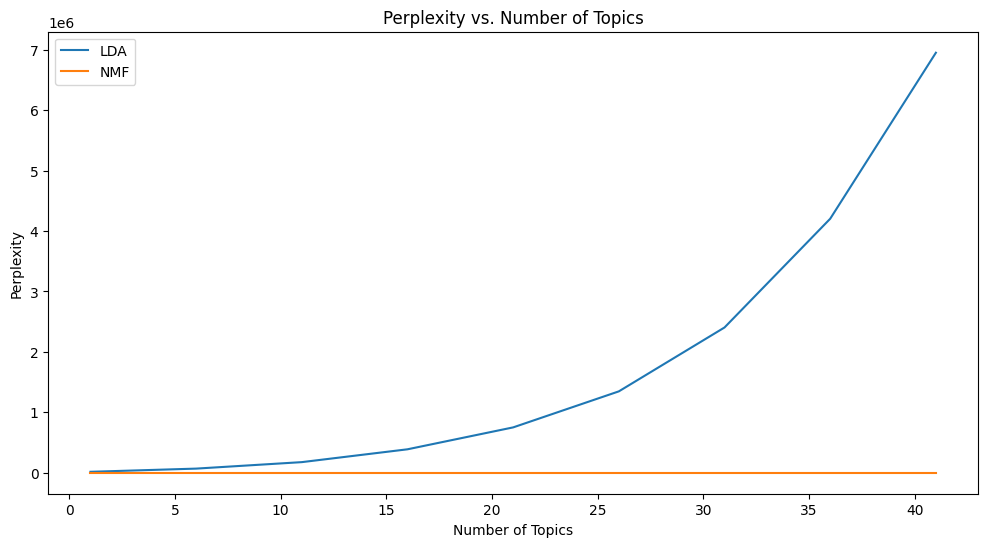

LDA Perplexities: [15643.480894701404, 68390.94501793574, 175577.8613298925, 387860.1647206176, 750364.478156188, 1346459.7391902925, 2403587.8798916247, 4202725.327770468, 6949591.6596959885]
NMF Perplexities: [384.83046797507586, 383.33301123735833, 382.20051740203195, 381.1934643396958, 380.2623087133662, 379.3644813132953, 378.52776276269753, 377.77999811319546, 376.9955824577101]


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split the data into training and testing sets
X_train, X_test = train_test_split(Test_strings, test_size=0.2, random_state=42)

# Create TF-IDF matrices for training and testing sets
tfidf_vectorizer_train = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix_train = tfidf_vectorizer_train.fit_transform(X_train)

tfidf_vectorizer_test = TfidfVectorizer(vocabulary=tfidf_vectorizer_train.vocabulary_)
tfidf_matrix_test = tfidf_vectorizer_test.fit_transform(X_test)

# Define the range of topics to test with increments of 5
num_topics_range = range(1, 42, 5)

# Lists to store perplexity scores for each model
lda_perplexities = []
nmf_perplexities = []

# Loop through different numbers of topics
for num_topics in num_topics_range:
    # Fit LDA model
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(tfidf_matrix_train)

    # Calculate perplexity on the test set and store it
    lda_perplexity = lda.perplexity(tfidf_matrix_test)
    lda_perplexities.append(lda_perplexity)

    # Fit NMF model
    nmf = NMF(n_components=num_topics, random_state=42)
    nmf.fit(tfidf_matrix_train)

    # Calculate perplexity on the test set and store it
    nmf_perplexity = nmf.reconstruction_err_
    nmf_perplexities.append(nmf_perplexity)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(num_topics_range, lda_perplexities, label='LDA')
plt.plot(num_topics_range, nmf_perplexities, label='NMF')
plt.title('Perplexity vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

# Print the results
print("LDA Perplexities:", lda_perplexities)
print("NMF Perplexities:", nmf_perplexities)

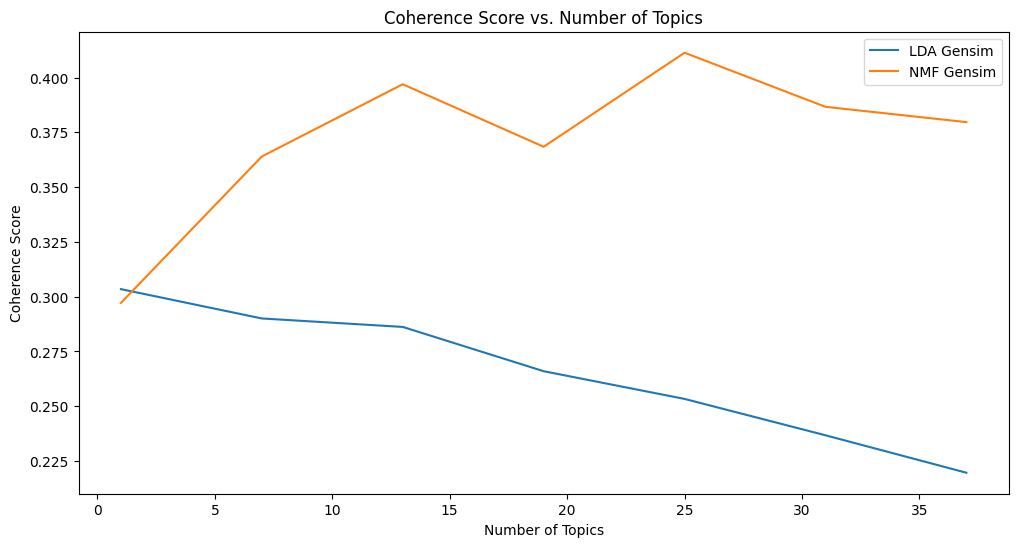

LDA Gensim Coherence Scores: [0.3034217521696173, 0.2900399257918308, 0.28617940818240706, 0.26597191321881786, 0.253327943884771, 0.23673118256381515, 0.21964472282586456]
NMF Gensim Coherence Scores: [0.29714619708343537, 0.36396285046532023, 0.396930418941536, 0.36838696147969585, 0.41131171018991, 0.3866222069593934, 0.3796457440079109]


In [ ]:
from gensim import matutils
from gensim.corpora import Dictionary
from gensim.models import Nmf, CoherenceModel
import matplotlib.pyplot as plt
import gensim  # Import gensim
from gensim.models import LdaModel

# Convertir la matrice TF-IDF en un format Gensim
corpus_gensim = gensim.matutils.Sparse2Corpus(tfidf_matrix.transpose())

# Créer un dictionnaire Gensim à partir des données lemmatizées
dictionary = Dictionary(l_texts)
corpus_gensim = [dictionary.doc2bow(text) for text in l_texts]

# Définir la plage de sujets à tester
num_topics_range = range(1, 42, 6)

# Listes pour stocker les scores de cohérence des sujets pour chaque modèle LDA et NMF
coherence_scores_lda = []
coherence_scores_nmf = []

# Loop through different numbers of topics
for num_topics in num_topics_range:
    # Créer un modèle LDA avec Gensim
    lda_gensim = LdaModel(corpus_gensim, num_topics=num_topics, id2word=dictionary, random_state=42)

    # Calculer la cohérence des sujets avec Gensim pour LDA
    coherence_model_lda = CoherenceModel(model=lda_gensim, texts=l_texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores_lda.append(coherence_lda)

    # Créer un modèle NMF avec Gensim
    nmf_gensim = Nmf(corpus_gensim, num_topics=num_topics, id2word=dictionary, random_state=42)

    # Calculer la cohérence des sujets avec Gensim pour NMF
    coherence_model_nmf = CoherenceModel(model=nmf_gensim, texts=l_texts, dictionary=dictionary, coherence='c_v')
    coherence_nmf = coherence_model_nmf.get_coherence()
    coherence_scores_nmf.append(coherence_nmf)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(num_topics_range, coherence_scores_lda, label='LDA Gensim')
plt.plot(num_topics_range, coherence_scores_nmf, label='NMF Gensim')
plt.title('Coherence Score vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend()
plt.show()

# Print the results
print("LDA Gensim Coherence Scores:", coherence_scores_lda)
print("NMF Gensim Coherence Scores:", coherence_scores_nmf)

Pour coherence, la plage la plus élevée était entre 13 et 30. cette plage est donc a prendre en considération. <br>
Pour perpléxité, j'ai recherché la plage de nombres de sujets où la perplexité semble stabiliser ou commencer à augmenter lentement pour les modèles et entre 7 et 20 ça me sempblait plus pertinant.<br><br>
Nous avons donc réduit notre plage entre 11 et 25.

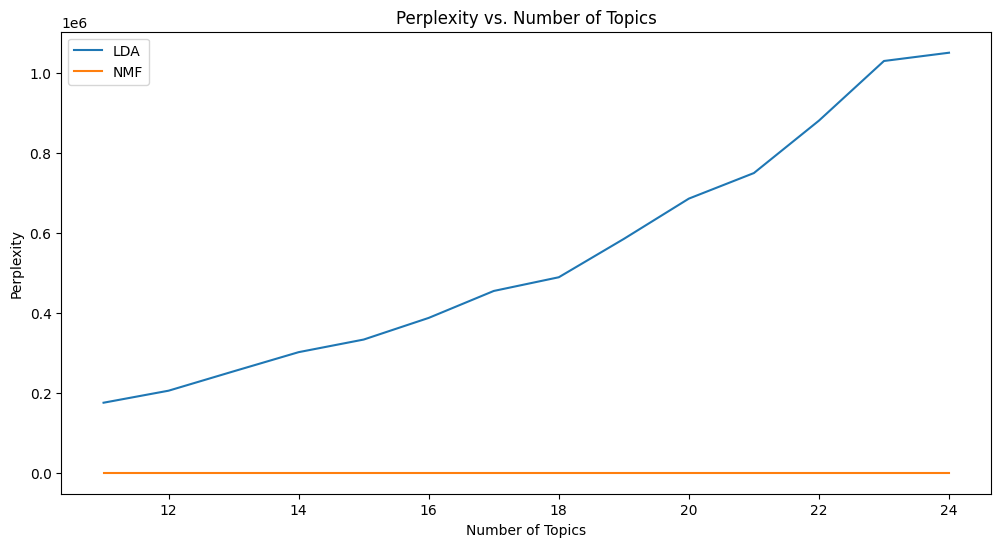

LDA Perplexities: [175577.8613298925, 205678.5932913854, 254162.60218693898, 302124.7555705814, 333666.6069940761, 387860.1647206176, 455272.8118703625, 489571.36532797746, 585543.4183891198, 686391.7041009703, 750364.478156188, 881541.1196383876, 1030827.0067104517, 1051500.560531779]
NMF Perplexities: [382.20051740203195, 381.995402495737, 381.7910301846327, 381.5858838057406, 381.38375566153803, 381.1934643396958, 381.00579906555816, 380.82067364311587, 380.6231407184469, 380.4368201170536, 380.2623087133662, 380.06647888105806, 379.88527230095775, 379.7266236756158]


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split the data into training and testing sets
X_train, X_test = train_test_split(Test_strings, test_size=0.2, random_state=42)

# Create TF-IDF matrices for training and testing sets
tfidf_vectorizer_train = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix_train = tfidf_vectorizer_train.fit_transform(X_train)

tfidf_vectorizer_test = TfidfVectorizer(vocabulary=tfidf_vectorizer_train.vocabulary_)
tfidf_matrix_test = tfidf_vectorizer_test.fit_transform(X_test)

# Define the range of topics to test with increments of 5
num_topics_range = range(11, 25, 1)

# Lists to store perplexity scores for each model
lda_perplexities = []
nmf_perplexities = []

# Loop through different numbers of topics
for num_topics in num_topics_range:
    # Fit LDA model
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(tfidf_matrix_train)

    # Calculate perplexity on the test set and store it
    lda_perplexity = lda.perplexity(tfidf_matrix_test)
    lda_perplexities.append(lda_perplexity)

    # Fit NMF model
    nmf = NMF(n_components=num_topics, random_state=42)
    nmf.fit(tfidf_matrix_train)

    # Calculate perplexity on the test set and store it
    nmf_perplexity = nmf.reconstruction_err_
    nmf_perplexities.append(nmf_perplexity)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(num_topics_range, lda_perplexities, label='LDA')
plt.plot(num_topics_range, nmf_perplexities, label='NMF')
plt.title('Perplexity vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

# Print the results
print("LDA Perplexities:", lda_perplexities)
print("NMF Perplexities:", nmf_perplexities)

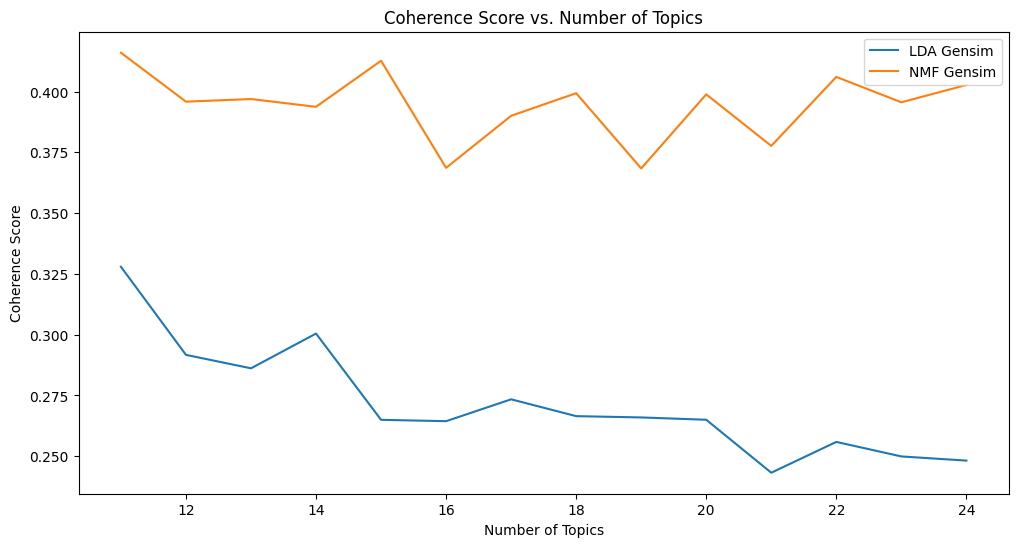

LDA Gensim Coherence Scores: [0.3279456825986991, 0.2917141303247155, 0.28617940818240706, 0.3004779344381983, 0.2649974205288942, 0.2644342337667115, 0.2734285918672513, 0.26650841287534566, 0.26597191321881786, 0.26502148497829986, 0.2432371152144456, 0.2559079723320053, 0.24993601011923677, 0.24822265878943273]
NMF Gensim Coherence Scores: [0.415978505178041, 0.3958535335902665, 0.396930418941536, 0.39372916396744706, 0.4126754358143326, 0.36862207970495375, 0.3900412776380818, 0.3993323784262849, 0.36838696147969585, 0.3988510158832913, 0.37765451050070037, 0.40602888032249085, 0.39559334968819376, 0.40271683018870563]


In [59]:
from gensim import matutils
from gensim.corpora import Dictionary
from gensim.models import Nmf, CoherenceModel
import matplotlib.pyplot as plt
import gensim  # Import gensim
from gensim.models import LdaModel

# Convertir la matrice TF-IDF en un format Gensim
corpus_gensim = gensim.matutils.Sparse2Corpus(tfidf_matrix.transpose())

# Créer un dictionnaire Gensim à partir des données lemmatizées
dictionary = Dictionary(l_texts)
corpus_gensim = [dictionary.doc2bow(text) for text in l_texts]

# Définir la plage de sujets à tester
num_topics_range = range(11, 25, 1)

# Listes pour stocker les scores de cohérence des sujets pour chaque modèle LDA et NMF
coherence_scores_lda = []
coherence_scores_nmf = []

# Loop through different numbers of topics
for num_topics in num_topics_range:
    # Créer un modèle LDA avec Gensim
    lda_gensim = LdaModel(corpus_gensim, num_topics=num_topics, id2word=dictionary, random_state=42)

    # Calculer la cohérence des sujets avec Gensim pour LDA
    coherence_model_lda = CoherenceModel(model=lda_gensim, texts=l_texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores_lda.append(coherence_lda)

    # Créer un modèle NMF avec Gensim
    nmf_gensim = Nmf(corpus_gensim, num_topics=num_topics, id2word=dictionary, random_state=42)

    # Calculer la cohérence des sujets avec Gensim pour NMF
    coherence_model_nmf = CoherenceModel(model=nmf_gensim, texts=l_texts, dictionary=dictionary, coherence='c_v')
    coherence_nmf = coherence_model_nmf.get_coherence()
    coherence_scores_nmf.append(coherence_nmf)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(num_topics_range, coherence_scores_lda, label='LDA Gensim')
plt.plot(num_topics_range, coherence_scores_nmf, label='NMF Gensim')
plt.title('Coherence Score vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend()
plt.show()

# Print the results
print("LDA Gensim Coherence Scores:", coherence_scores_lda)
print("NMF Gensim Coherence Scores:", coherence_scores_nmf)

Notre choix final est donc 14, car nous avons fait un compromis entre une perplexité relativement basse (indiquant une bonne capacité de généralisation) et un score de cohérence élevé (indiquant des sujets sémantiquement cohérents)

On applique l'algorithme Latent Dirichlet Allocation pour découvrir cinq sujets différents dans un corpus de textes. LDA est une méthode de modélisation probabiliste qui attribue à chaque document une distribution de probabilité sur ces cinq sujets. Le modèle est ajusté sur une matrice TF-IDF précédemment créée, et le résultat, stocké dans lda_topics, offre une représentation numérique de chaque document en termes de sa probabilité d'appartenance à chaque sujet. Cette approche permet de structurer le corpus en révélant les thèmes majeurs présents dans les textes.

In [ ]:
# LDA
lda = LatentDirichletAllocation(n_components=14, random_state=42)
lda_topics = lda.fit_transform(tfidf_matrix)

On utilise l'algorithme NMF pour identifier 18 thèmes distincts à partir de la matrice TF-IDF. Chaque document est représenté numériquement en fonction de sa contribution aux thèmes identifiés par NMF. Cela offre une vision structurée des sujets présents dans le corpus, facilitant l'analyse des tendances et des motifs.

In [ ]:
# NMF
nmf = NMF(n_components=14, random_state=42)
nmf_topics = nmf.fit_transform(tfidf_matrix)

## **Partie 4 : Metrics**


Le score de silhouette (silhouette score) est une métrique utilisée pour évaluer la qualité de la séparation des clusters dans un ensemble de données. Il mesure à quel point les points d'un cluster sont similaires les uns aux autres par rapport aux points des autres clusters. L'objectif est d'obtenir des clusters bien définis et séparés. Ainsi plus le score est proche de 1 mieux seras notre clustering

Dans le cas du modèle LDA (Latent Dirichlet Allocation), un score de silhouette de 0.55 est relativement élevé, indiquant une bonne cohésion intra-cluster et une séparation inter-cluster significative. Cela suggère que les sujets générés par le modèle LDA sont distincts les uns des autres, et les documents attribués à ces sujets sont similaires entre eux.

In [ ]:
#Silhouette Score LDA
lda_silhouette_score = silhouette_score(lda_topics, np.argmax(lda_topics, axis=1))
print("LDA Silhouette Score:", lda_silhouette_score)

LDA Silhouette Score: 0.5559083291650198


Le score de silhouette pour le modèle NMF (Non-Negative Matrix Factorization) est de 0.34. Ce score, bien que positif, indique une cohésion relativement modérée entre les points au sein des clusters formés. Cette valeur suggère une certaine ambiguïté dans la séparation des clusters, suggérant que les thèmes identifiés par le modèle NMF pourraient ne pas être aussi distincts les uns des autres que ceux générés par le modèle LDA.

In [ ]:
#Silhouette Score NMF
nmf_silhouette_score = silhouette_score(nmf_topics, np.argmax(nmf_topics, axis=1))
print("NMF Silhouette Score:", nmf_silhouette_score)

NMF Silhouette Score: 0.34278238559581475


In [ ]:
# Convertir la liste de listes en DataFrame
df_afusionner = pd.DataFrame({'combined_text': Test_strings})

# Afficher le DataFrame
print(df_afusionner)

                                            combined_text
0       mass_shooting texas tv leave husband kill chil...
1       smith join diplo nicky jam world_cup official ...
2       hugh grant marries age actor longtime girlfrie...
3       jim_carrey blasts castrato adam schiff democra...
4       julianna margulie donald poop bag pick dog die...
...                                                   ...
185848  rim ceo thorsten hein significant plan blackbe...
185849  maria_sharapova stun victoria azarenka austral...
185850  giant patriot jet colt improbable super_bowl u...
185851  aldon smith arrest ers linebacker bust dui cor...
185852  dwight rip teammate magic loss hornets star ce...

[185853 rows x 1 columns]


In [ ]:
from sklearn.cluster import KMeans
# Appliquer KMeans sur les distributions de topics
num_clusters = 14  # Vous pouvez ajuster le nombre de clusters
kmeans_topics = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
df_afusionner['topic_cluster'] = kmeans_topics.fit_predict(lda_topics)

In [ ]:
print(df_afusionner[['combined_text', 'topic_cluster']])

                                            combined_text  topic_cluster
0       mass_shooting texas tv leave husband kill chil...              0
1       smith join diplo nicky jam world_cup official ...             11
2       hugh grant marries age actor longtime girlfrie...             10
3       jim_carrey blasts castrato adam schiff democra...              8
4       julianna margulie donald poop bag pick dog die...              8
...                                                   ...            ...
185848  rim ceo thorsten hein significant plan blackbe...              7
185849  maria_sharapova stun victoria azarenka austral...              0
185850  giant patriot jet colt improbable super_bowl u...             11
185851  aldon smith arrest ers linebacker bust dui cor...              6
185852  dwight rip teammate magic loss hornets star ce...              8

[185853 rows x 2 columns]


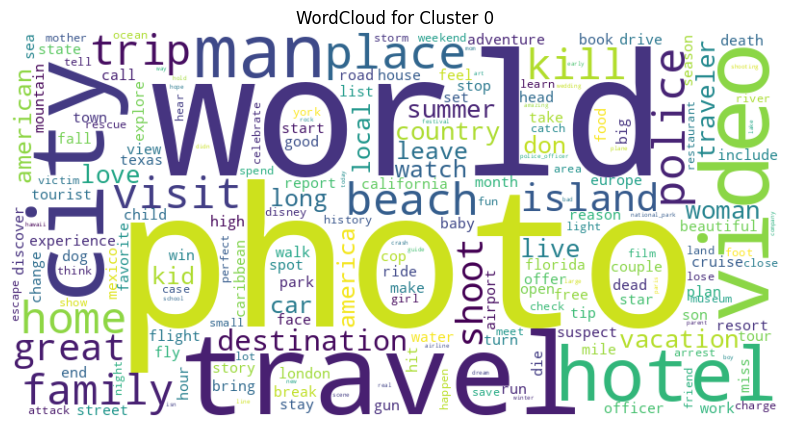

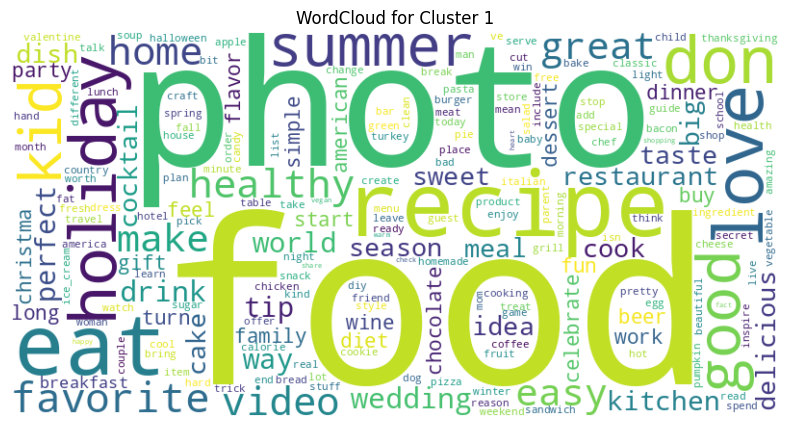

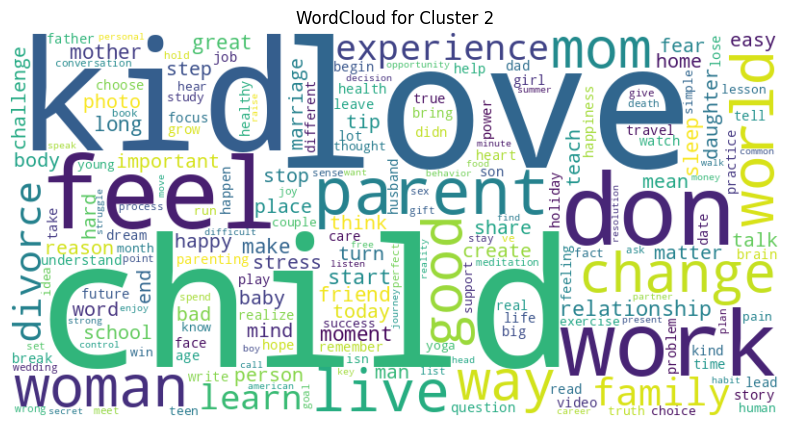

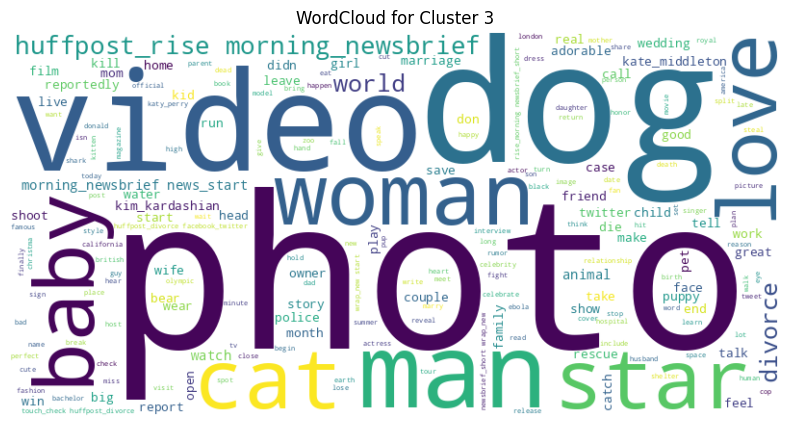

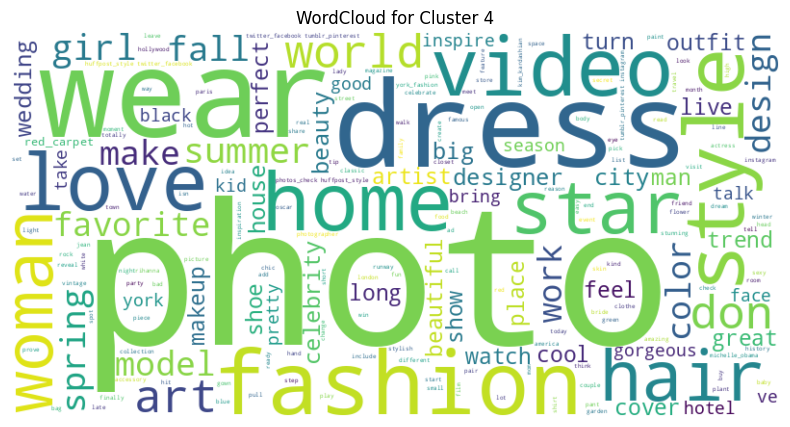

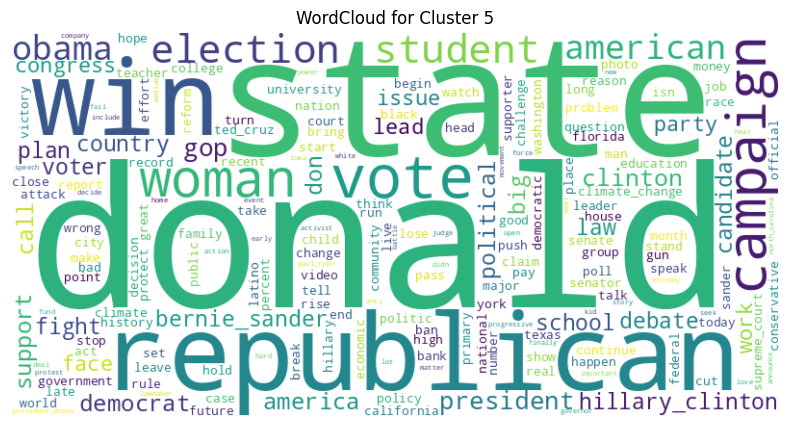

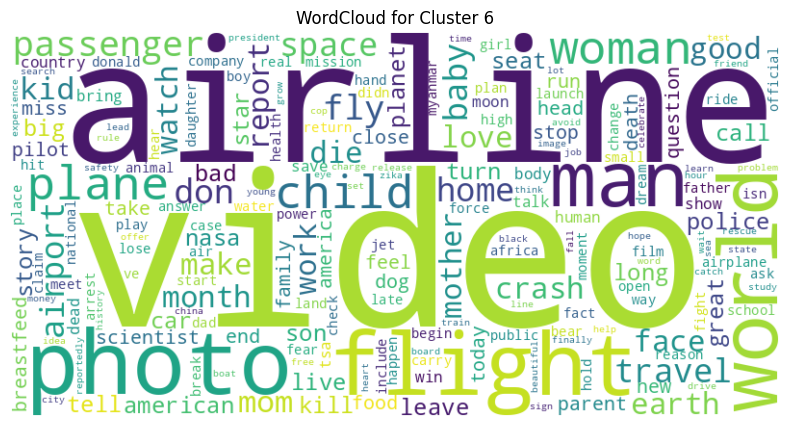

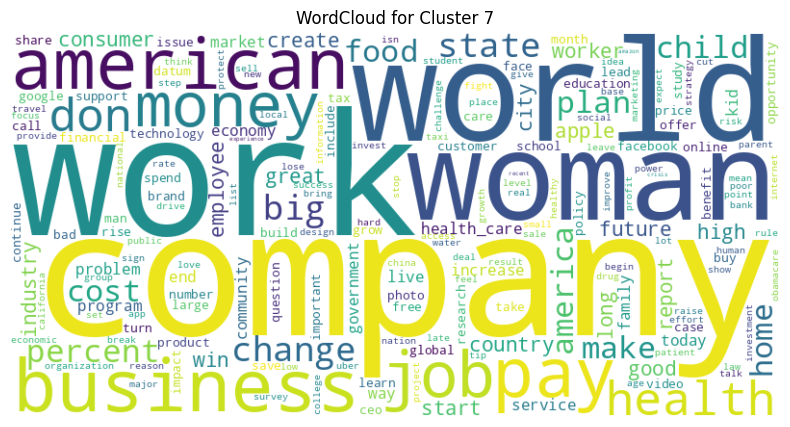

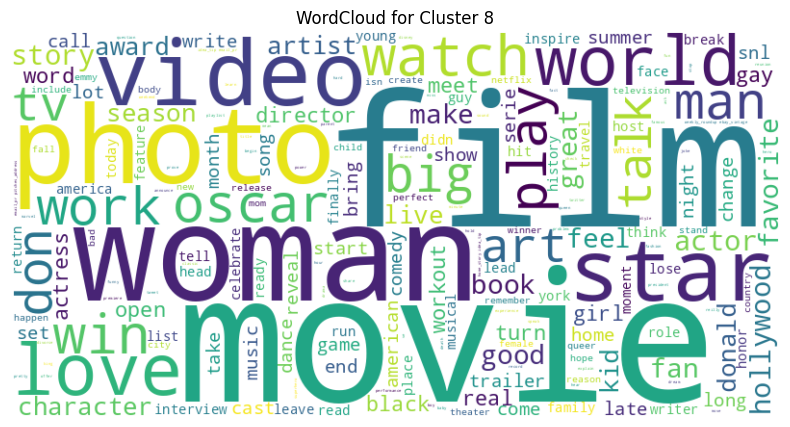

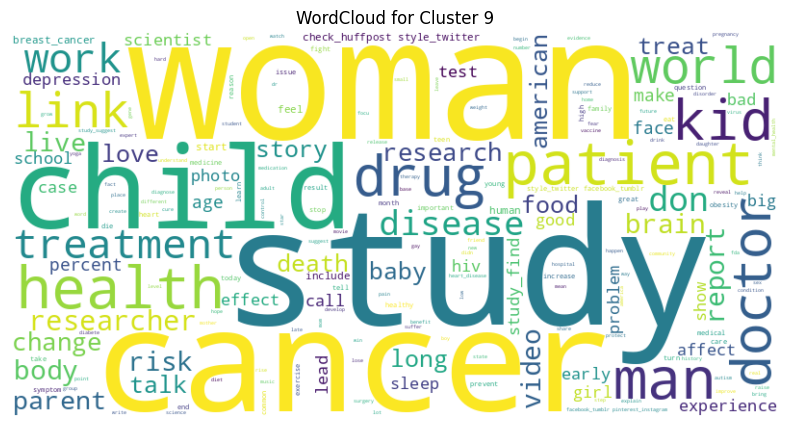

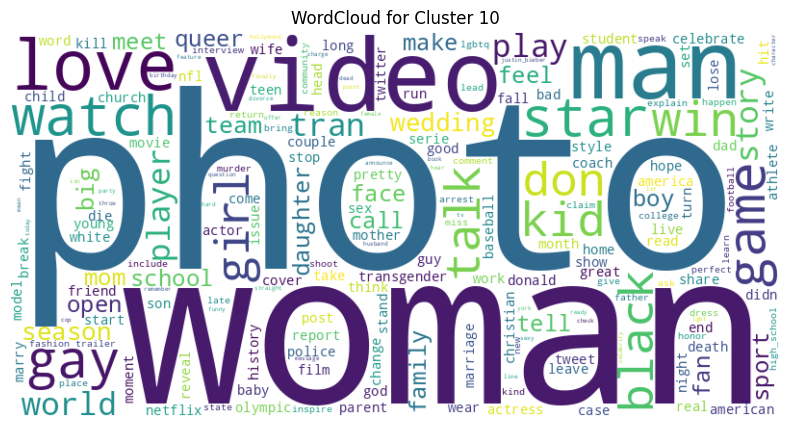

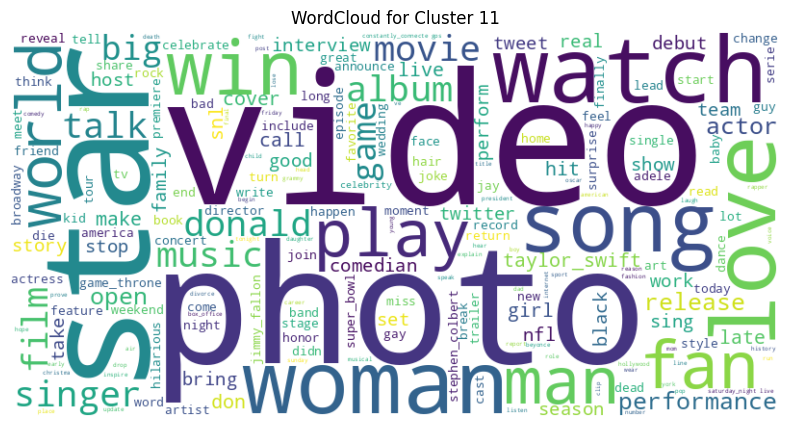

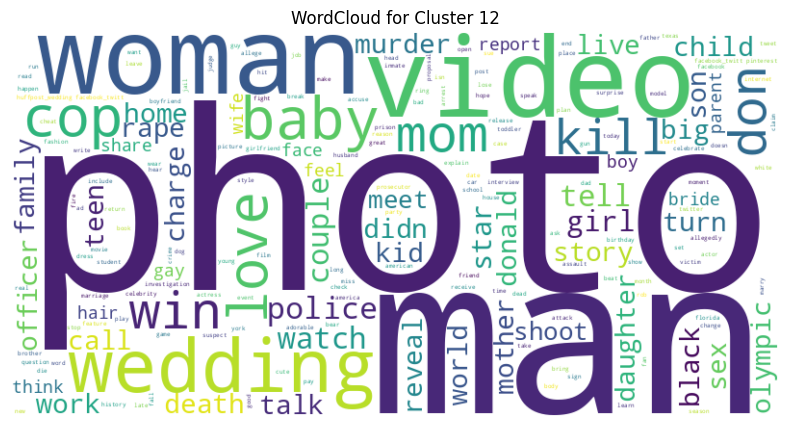

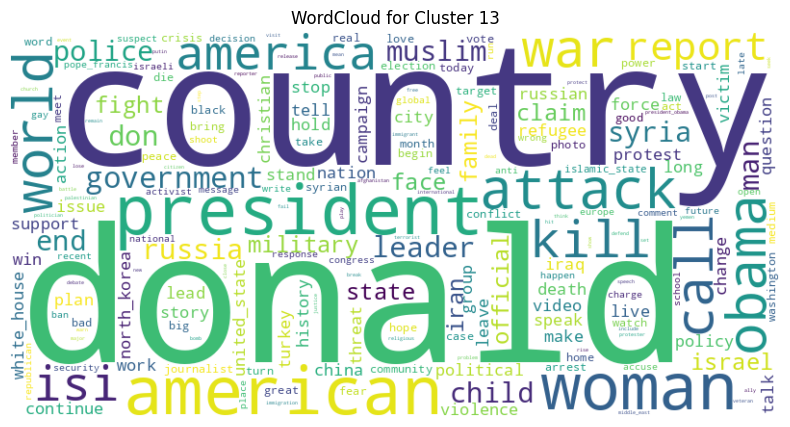

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Créer un WordCloud basé sur les termes les plus fréquents dans chaque cluster/topic
def generate_wordcloud_for_cluster(cluster_id, df_afusionner, text_column='combined_text'):
    cluster_text = ' '.join(df_afusionner[df_afusionner['topic_cluster'] == cluster_id][text_column])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for Cluster {cluster_id}')
    plt.show()

# Générer et afficher le WordCloud pour chaque cluster
for cluster_id in range(num_clusters):
    generate_wordcloud_for_cluster(cluster_id, df_afusionner)

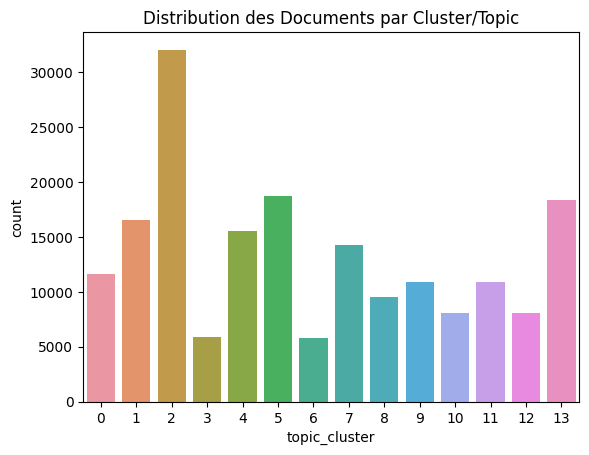

In [ ]:
import seaborn as sns

sns.countplot(x='topic_cluster', data=df_afusionner)
plt.title('Distribution des Documents par Cluster/Topic')
plt.show()

PylDAVIS NON FONCTIONNEL

Nous souhaitons maintenant illustrer nos clusters via PyLDAvis car celui ci offre une représentations graphiques intuitives et d'évaluations de cohérence ce qui est parfait pour la visualisation de modèles de topics dans le contexte du NLP, en particulier lorsqu'on utilise des méthodes comme LDA

In [ ]:
!pip install pyLDAvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim
import pandas as pd

# Création d'une DataFrame avec une colonne 'tokens'
df_test_string = pd.DataFrame({'Test_String': Test_strings})

# Tokenisation des phrases en une liste de mots
df_test_string['tokens'] = df_test_string['Test_String'].apply(lambda x: x.split())

# Remove NaN or non-string values in the 'tokens' column
df_test_string = df_test_string.dropna(subset=['tokens'])
df_test_string['tokens'] = df_test_string['tokens'].apply(lambda x: [str(word) for word in x])

# Create a dictionary
dictionary = corpora.Dictionary(df_test_string['tokens'])

# Create a corpus
bow_corpus = [dictionary.doc2bow(tokens) for tokens in df_test_string['tokens']]

# Train an LDA model
num_topics = 14  # You can adjust the number of topics
lda_model = LdaModel(bow_corpus, num_topics=num_topics)

# Visualize the topics using pyLDAvis
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=bow_corpus, dictionary=dictionary, n_jobs=1)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Part 5 : Conclusion

Pour conclure, nous avons pris plusieurs décisions importantes au cours de notre projet. Nous avons conservé la diversité des mots tout en simplifiant l'analyse en se concentrant sur les colonnes "HEADLINE" et "SHORT_DESCRIPTION" et en éliminant les éléments non essentiels.
La réduction de l'échelle de la catégorie « POLITIQUES » visait à équilibrer les données, évitant une influence disproportionnée.
La qualité des données a été améliorée grâce au prétraitement, qui an éliminé les stopwords et géré les bigrammes et les trigrammes.
Après avoir fait une étude sur la complexité ainsi que le score de cohérence, nous avons déduis qu’il était plus intéressant à la fois pour l’algorithme LDA et NMF de prendre un nombre de topics égale à 14. Cette étude a été faite après des analyses de graphes en choisissant le meilleur nombre de cluster ayant à la fois une bonne capacité de généralisation et un score de cohérence élevé.
Le LDA et NMF (Non-Negative Matrix Factorization) sont deux approches de topic modeling pour extraire des thèmes de documents textuels. Cependant le LDA a une meilleure interprétabilité avec des distributions probabilistes de mots pour un sujet en particilier, ce qui facilite la compréhension des différents thèmes.
Pour perfectionner notre approche, nous aurions pu élargir nos données en les enrichissant avec d'autres sources, explorer diverses configurations de modèles, et affiner la liste des stopwords pour accroître la pertinence des thèmes identifiés. Une évaluation approfondie des modèles, l'utilisation de méthodes de visualisation, et l'exploration d'autres algorithmes auraient certainement ouvert des perspectives enrichissantes. En intégrant les données temporelles et en analysant les erreurs du modèle, nous aurions pu consolider la qualité et la précision de notre analyse de topic modeling.